# Amazon Alexa Review Sentiment Analysis: pos, neu, neg

- Sentiment analysis on amazon product's review  - Amazon Echo White

In [ ]:
# add gitinore 
# download and extract data from kaggle or json file..
# don't track json, zip, csv, DS_store file

In [5]:
# installing the kaggle library to fetch the dataset from kaggle 

%pip install kaggle 

# configuring 
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle / 
!chmod 600 ~/.kaggle/kaggle.json

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
cp: /kaggle.json: Read-only file system
cp: /Users/rt/.kaggle is a directory (not copied).


In [6]:
# API to fetch the dataset from kaggle:
! kaggle datasets download -d sid321axn/amazon-alexa-reviews

/Users/rt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Dataset URL: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews
License(s): other
amazon-alexa-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# extracting the dataset we just downloaded
from zipfile import ZipFile
dataset_path = "./amazon-alexa-reviews.zip"
with ZipFile(dataset_path, "r") as zip:
    zip.extractall(".")
    print("Dataset extracted successfully")

Dataset extracted successfully


### Importing required libraries: 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle 
import re
%pip install wordcloud
%pip install xgboost

from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /Users/rt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Exploratory Data Analysis: 

In [9]:
# load the data: 
data = pd.read_csv(r"./amazon_alexa.tsv", delimiter = '\t', quoting=3)
print("Database shape", data.shape)

Database shape (3150, 5)


In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [11]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [12]:
# check the data types of each columns present in the dataset. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [13]:
# checking if there are any null values in the dataset. 
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with 'verified_reviews' null value.

In [14]:
# check out which exactly one row has a verified_reviews null (N/A) value. 
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


We're dropping this record since it's only one data record, it may not have that much impact on the result of the our sentiment analysis.

In [15]:
data.dropna(inplace=True)
data.shape

(3149, 5)

In [16]:
# creating and adding a new variable /new column called 'length' which denotes the length of the string in verified reviews. 

data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


## Analyzing the rating column: 
- Column refers to the rating of the variation given by user

In [17]:
data['rating'].value_counts(), data['feedback'].value_counts()

(rating
 5    2286
 4     455
 1     161
 3     152
 2      95
 Name: count, dtype: int64,
 feedback
 1    2893
 0     256
 Name: count, dtype: int64)

Here, most of the rating are 5 stars rating

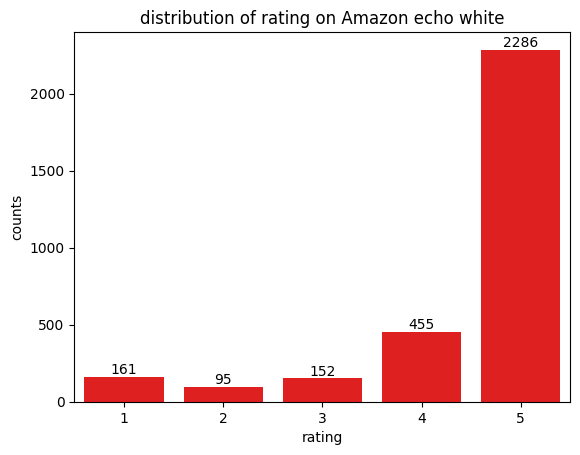

In [18]:
# plot the rating in the plot: 
ax=sns.countplot(x='rating', data=data, color='red')
plt.title("distribution of rating on Amazon echo white")
plt.xlabel('rating')
plt.ylabel('counts')
ax.bar_label(ax.containers[0])
plt.show()

Text(0.5, 1.0, 'distribution of rating on amazon echo white using pie charts')

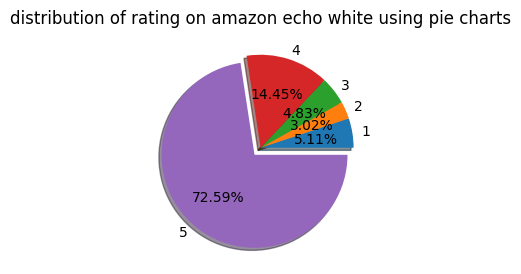

In [19]:
plt.figure(figsize=(3,4))
explode=(0,0,0,0,0.1)
gb=data.groupby("rating").agg({"rating":"count"})
plt.pie(gb['rating'], labels=gb.index, autopct='%1.2f%%', explode=explode, shadow=True)
plt.title("distribution of rating on amazon echo white using pie charts")


## Analyzing the feedback column: 

In [20]:
# checking counts of each feedback values: 
data["feedback"].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are two distinct feeedback values. 

In [ ]:
# extracting the 'verified_reviews' value for one record with feedback = 0, =1. 
# what does feedback ==1 indicate? let's look at its correspoding verified reviews

review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']


print(review_1)
print(review_0)

Sound is terrible if u want good music too get a bose
Loved it!


From above results, we can see that feedback **0 is negative review** and **1 is positive review.**

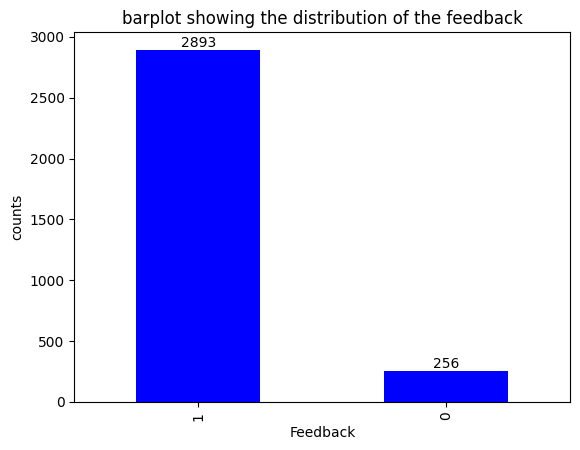

In [22]:
# let's plot the feedback value counts in a bar graph. 
# bar grpah to visualize the total counts of each feedback

ax = data['feedback'].value_counts().plot.bar(color='blue')
plt.title("barplot showing the distribution of the feedback")
plt.xlabel('Feedback')
plt.ylabel('counts')
ax.bar_label(ax.containers[0])
plt.show()

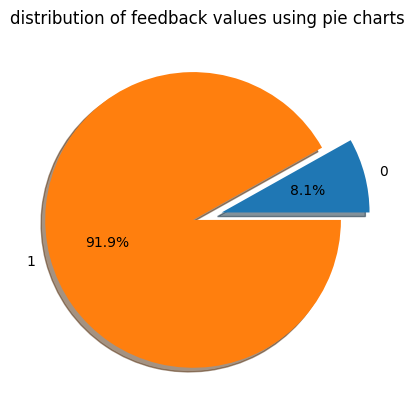

In [23]:
explode= (0.1,0.1)
gb = data.groupby("feedback").agg({'feedback':'count'})
plt.pie(gb['feedback'], explode=explode,labels=gb.index, autopct='%1.1f%%',shadow=True)
plt.title("distribution of feedback values using pie charts")
plt.show()

### Let's see the 'rating' values for different values of 'feedback'

In [24]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

From these results, we observe that negative feedback (0) corresponds to ratings of 1 and 2. Therefore, ratings of 1 or 2 are classified as negative feedback, while ratings of 3, 4, or 5 are classified as positive feedback (1).

In [25]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Rating 3,4, and 5 indicate the positive feedback. 

## Analyzing 'variation' column:

Text(0.5, 1.0, 'distribution of vartion of the product amazon echo white / variation distribution count')

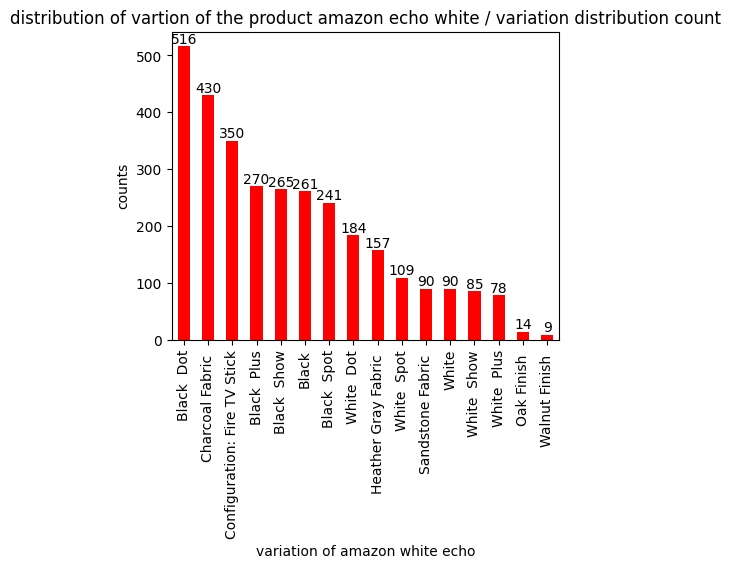

In [26]:
plt.figure(figsize=(5,4))
ax=data['variation'].value_counts().plot.bar(color='red')
ax.bar_label(ax.containers[0])
plt.xlabel("variation of amazon white echo")
plt.ylabel("counts")
plt.title('distribution of vartion of the product amazon echo white / variation distribution count')

#### mean of 'rating' according to 'variation'

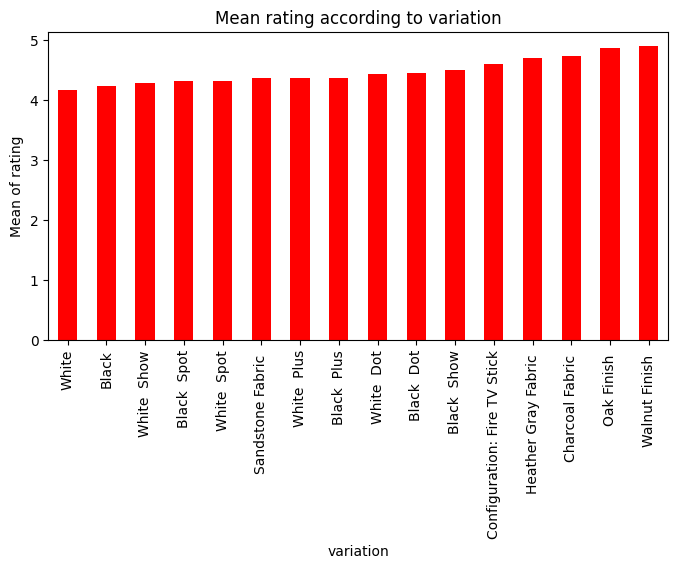

In [27]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='red', figsize=(8,4))
plt.xlabel("variation")
plt.ylabel("Mean of rating")
plt.title("Mean rating according to variation")
plt.show()

People who bought "Walnut Finish" variation have higher average rating (or are more happier) than rest of other variations.

## Analyzing the "verified_reviews" column
- This column contains the textual review given by the user for a variation for the product. 

In [28]:
data['length'].describe()  #info, .dtypes

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

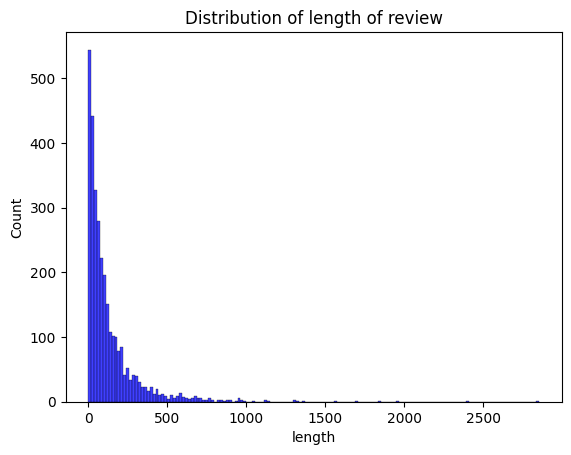

In [29]:
# length analysis for the full dataset
sns.histplot(data['length'], color="blue").set(title="Distribution of length of review")

The results show that the majority of reviews have a length of 0, indicating that many users skip writing feedback and provide only a rating without any written comment.

It would be interesting to see no.of positive and negative review having different length of review

[Text(0.5, 1.0, 'distribution of length review if feedback review is 0 (negative)')]

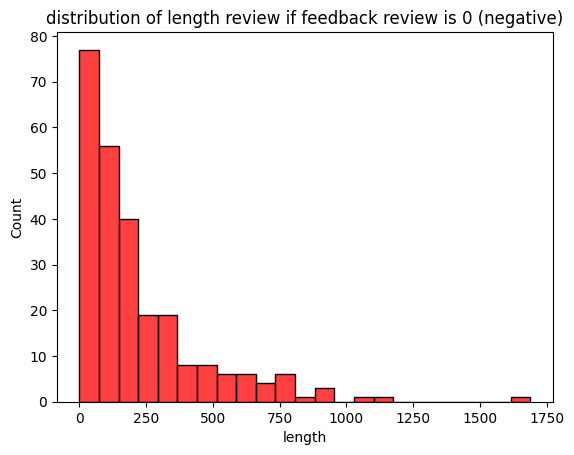

In [30]:
sns.histplot(data[data['feedback']==0]['length'], color='red').set(title="distribution of length review if feedback review is 0 (negative)")

Text(0.5, 1.0, 'distribution of length review if feedback review is 1 (positive)')

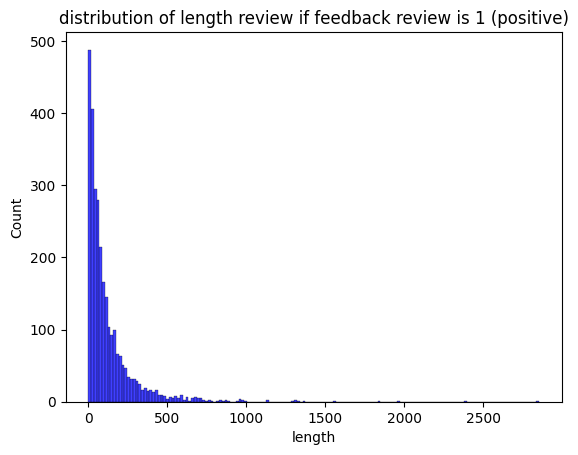

In [31]:
sns.histplot(data[data['feedback']==1]['length'], color='blue').set_title("distribution of length review if feedback review is 1 (positive)")

##### Likewise mean rating: 

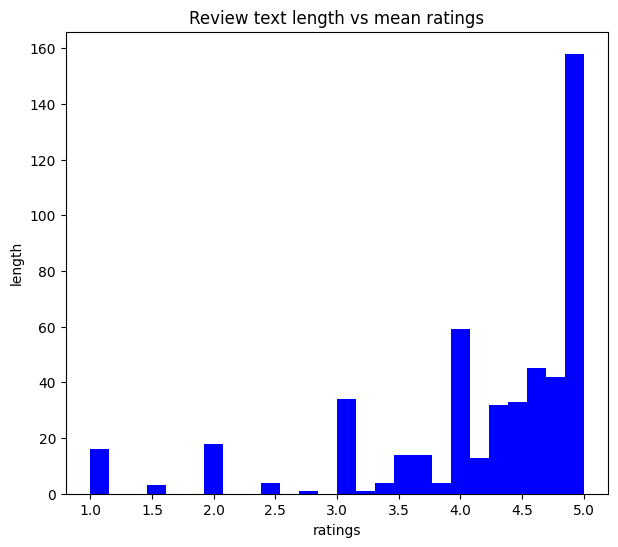

In [32]:
data.groupby('length')['rating'].mean().plot.hist(color="blue", figsize=(7,6), bins=26)
plt.xlabel("ratings")
plt.ylabel("length")
plt.title("Review text length vs mean ratings")
plt.show()

This shows that 5-star ratings are more frequent (denser) and that positive ratings tend to have longer review texts than negative ones. This may be because users are more expressive when sharing positive experiences.

## WORD CLOUD

In [33]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

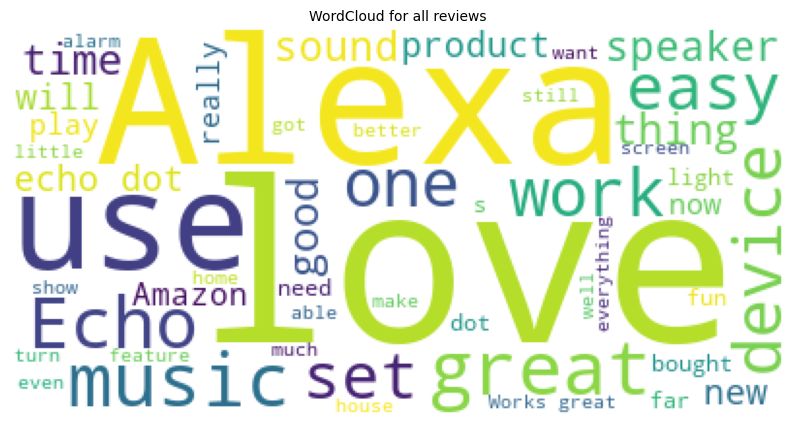

In [34]:
# combine all reviews: 
reviews = " ".join([review for review in data['verified_reviews']])


#initialize wordcloud object: 
wc = WordCloud(background_color='white', max_words=50)


#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))                   # reviews - for all words
plt.title('WordCloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Let's find unique words in each category:

In [35]:
 
# combine all reviews for each feedback category and splitting time into individual words. 

neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()


pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()


# finding words from reviews which are present in that feedback category only: 
unique_negative  = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative) 

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

Unique positive reviews words: 

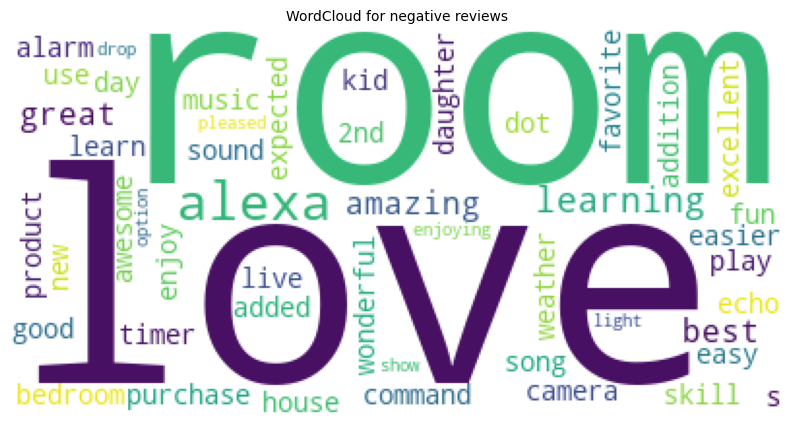

In [36]:

#initialize wordcloud object: 
wc = WordCloud(background_color='white', max_words=50)


#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))                           # pos reviews
plt.title('WordCloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

The unique positive most used words are love, alexa, room, learning, amazing, etc. ..

Unique negative reviews words: 

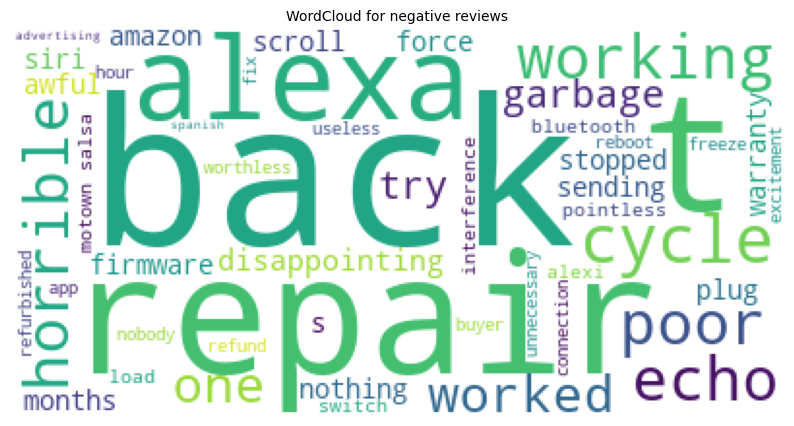

In [37]:
#initialize wordcloud object: 
wc = WordCloud(background_color='white', max_words=50)


#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))                           # neg reviews
plt.title('WordCloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

The unique negative most used words are back, repair, alexa, horrible, garbage, worked, etc. ..

# 2. Preprocessing and Modelling
- To build the corpus from the 'verified_reviews" we perform the following: 
1. Replace any non-alphabetical characters with a space
2. Convert to lower case and split into words 
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus. 



In [38]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]',  ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

- Using count vectorizer to create a bag of words
- Count Vectorizer is just a tool to convert the textual representation into numerical representation, because machine learning models don't understand categorical data. It's a part of skikit learning library. 

In [39]:
cv = CountVectorizer(max_features=2500)

# Storing independent and dependent variables in X and Y: 
X = cv.fit_transform(corpus).toarray()
y=data['feedback'].values

In [40]:
# saving the count vectorizer 
pickle.dump(cv, open("./countVectorizer.pkl", 'wb'))

Checking the shape of X and y

In [41]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing

In [42]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=15)
print(f"X_train:{X_train.shape}")
print(f"y_train:{y_train.shape}")
print(f"X_test:{X_test.shape}")
print(f"y_test:{y_test.shape}")

X_train:(2204, 2500)
y_train:(2204,)
X_test:(945, 2500)
y_test:(945,)


In [43]:
print(f"X train max value:{X_train.max()}")
print(f"X test max value:{X_test.max()}")

X train max value:12
X test max value:10


We'll scale X_train and X_test so that all values are between 0 and 1. 

Once, the data is ready we go through scaling or feature engineering techniques 

In [44]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)


In [45]:
# saving the scaler model: 
pickle.dump(scaler, open('./scaler.pkl', 'wb'))



## Random Forest:

In [46]:
# Fitting scaled X_train and y_train on Random Forest Classifier: 
model_rf = RandomForestClassifier()                   # add up mmore parameter
model_rf.fit(X_train_scl, y_train)


RandomForestClassifier()

In [47]:
# Accuracy of the model on training and testing data: 
print("Training Accuracy:", model_rf.score(X_train_scl, y_train))
print("Teseting Accuracy:", model_rf.score(X_test_scl, y_test))

Training Accuracy: 0.9945553539019963
Teseting Accuracy: 0.9492063492063492


In [48]:
# Predicting on the test set: 
y_preds = model_rf.predict(X_test_scl)

In [49]:
# Confusion matrix: 
cm = confusion_matrix(y_test, y_preds)

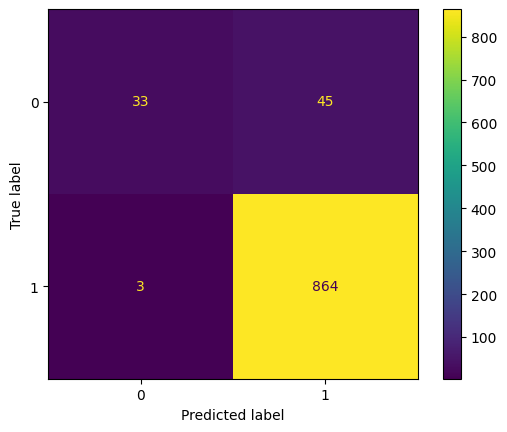

In [50]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

## K-fold cross validation: 

In [51]:
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=10)
print("Accuracy:", accuracies.mean())
print("Standard Variation:", accuracies.std())

Accuracy: 0.9319457013574661
Standard Variation: 0.008338152749457463


Applying grid seach to get the optimal parameters on random forest: 

In [52]:
params = {
    'bootstrap': [True],
    'max_depth': [80,100],
    'min_samples_split': [8,12],
    'n_estimators':[100,300]
}

In [53]:
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [54]:
# getting the best parameters from the grid search: 

print("Best parameter Combination: {}".format(grid_search.best_params_))

Best parameter Combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [55]:
print("Cross validation mean accuracy on train set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set: {}", accuracy_score(y_test, y_preds))


Cross validation mean accuracy on train set: 96.78425589836661
Cross validation mean accuracy on test set: 92.19033575317604
Accuracy score for test set: {} 0.9492063492063492


## XgBoost: 

In [56]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
# accuracy of the model on the training and test data
# Accuracy of the model on training and testing data: 

print("Training Accuracy:", model_xgb.score(X_train_scl, y_train))
print("Teseting Accuracy:", model_xgb.score(X_test_scl, y_test))

Training Accuracy: 0.971415607985481
Teseting Accuracy: 0.9417989417989417


## Get real insights from these testing and training accuracy for cv k fold and random forest classifier

In [58]:
y_preds = model_xgb.predict(X_test)

In [59]:
# Confusion_matrix: 
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


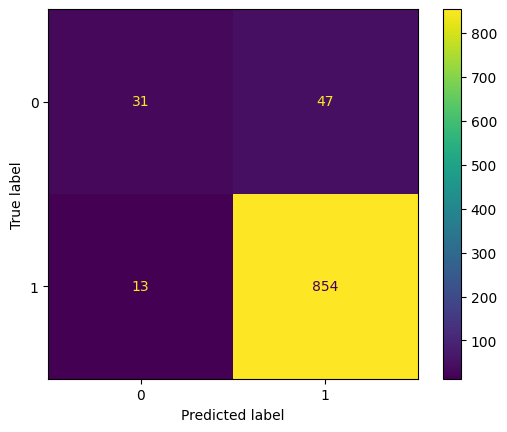

In [60]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [61]:
# saving the xgb classifier 
pickle.dump(model_xgb, open("./model_xgb.pkl", 'wb'))

## Decision Tree Classifier: 

In [62]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [63]:
# Accuracy of the model on training and testing data: 

print("Training Accuracy:", model_dt.score(X_train_scl, y_train))
print("Teseting Accuracy:", model_dt.score(X_test_scl, y_test))

Training Accuracy: 0.9945553539019963
Teseting Accuracy: 0.9216931216931217


In [64]:
y_preds = model_dt.predict(X_test)

In [65]:
# confusion matrix
# Confusion_matrix: 
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 40  38]
 [104 763]]


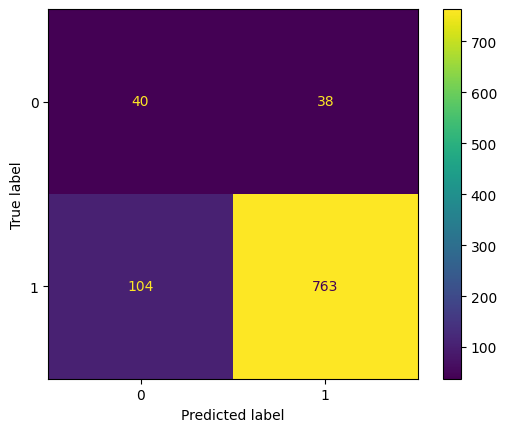

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [67]:
# saving the decision tree classifier 
pickle.dump(model_dt, open("./model_dt.pkl", 'wb'))

# Finetune further, try to balancing out the data (upsampling, downsampling), 

KeyError: 1